## ML1 Homework 3. Machine Learning Classifiers
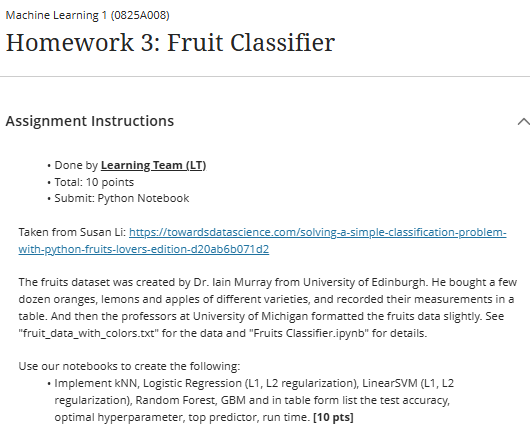  
https://towardsdatascience.com/multiclass-classification-evaluation-with-roc-curves-and-roc-auc-294fd4617e3a/

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from math import ceil
# import plotly.express as px
# import plotly.io as pio
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier


In [3]:
fruits = pd.read_table('fruit_data_with_colors.txt')
fruits.head()

,fruit_label,fruit_name,fruit_subtype,mass,width,height,color_score
0,1,apple,granny_smith,192,8.4,7.3,0.55
1,1,apple,granny_smith,180,8.0,6.8,0.59
2,1,apple,granny_smith,176,7.4,7.2,0.60
3,2,mandarin,mandarin,86,6.2,4.7,0.80
4,2,mandarin,mandarin,84,6.0,4.6,0.79


In [4]:
print(fruits['fruit_name'].unique())

['apple' 'mandarin' 'orange' 'lemon']


In [5]:
print(fruits.shape)

(59, 7)


## Exploratory Data Analysis
### Statistical Summary

In [6]:
fruits.describe()

,fruit_label,mass,width,height,color_score
count,59.000000,59.000000,59.000000,59.000000,59.000000
mean,2.542373,163.118644,7.105085,7.693220,0.762881
std,1.208048,55.018832,0.816938,1.361017,0.076857
min,1.000000,76.000000,5.800000,4.000000,0.550000
25%,1.000000,140.000000,6.600000,7.200000,0.720000
50%,3.000000,158.000000,7.200000,7.600000,0.750000
75%,4.000000,177.000000,7.500000,8.200000,0.810000
max,4.000000,362.000000,9.600000,10.500000,0.930000


We can see that the numerical values do not have the same scale. We will need to apply scaling to the test set that we computed for the training set.

### Fruit type distribution

In [7]:
print(fruits.groupby('fruit_name').size())

fruit_name
apple       19
lemon       16
mandarin     5
orange      19
dtype: int64


C:\Users\Enzo\AppData\Local\Temp\ipykernel_74860\1673128641.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(fruits['fruit_name'], palette=["red", "blue", "orange", "yellow"], label="Count")


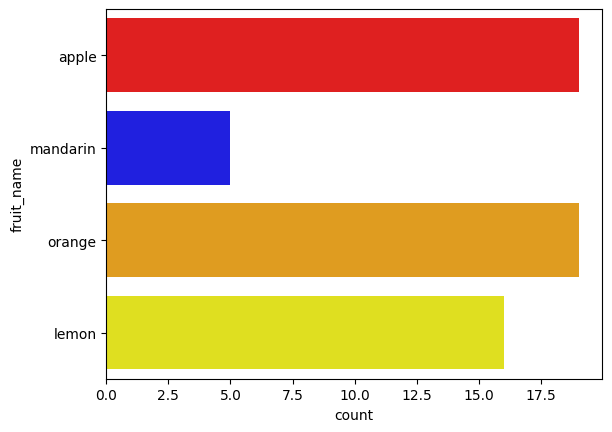

In [8]:
import seaborn as sns
sns.countplot(fruits['fruit_name'], palette=["red", "blue", "orange", "yellow"], label="Count")
plt.show()

The data is pretty balanced except mandarin. We will just have to go with it. 

Box plot for each numeric variable will give us a clearer idea of the distribution of the input variables:

In [9]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

num_df = fruits.drop('fruit_label', axis=1).select_dtypes(include='number')
cols = list(num_df.columns)

fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=cols[:4],  # adjust if >4 variables
    horizontal_spacing=0.08,  # ↓ tighter horizontally (default 0.2)
    vertical_spacing=0.08     # ↓ tighter vertically (default 0.3)
)

i = 0
for r in range(1, 3):
    for c in range(1, 3):
        if i < len(cols):
            colname = cols[i]
            fig.add_trace(
                go.Box(y=num_df[colname], name=colname, boxmean=True),
                row=r, col=c
            )
            i += 1

fig.update_layout(
    height=850, width=500,
    title=dict(
        text='Box Plot for each input variable',
        x=0.5, xanchor='center'
    ),
    showlegend=False,
    margin=dict(l=40, r=20, t=80, b=40),  # tighter margins
    font=dict(size=12)
)

fig.update_xaxes(title_text="")
fig.update_yaxes(title_text="Value")

# fig.write_html('fruits_boxplot.html')
fig.show()
# Optional: fig.write_image('fruits_boxplot.png', scale=2)


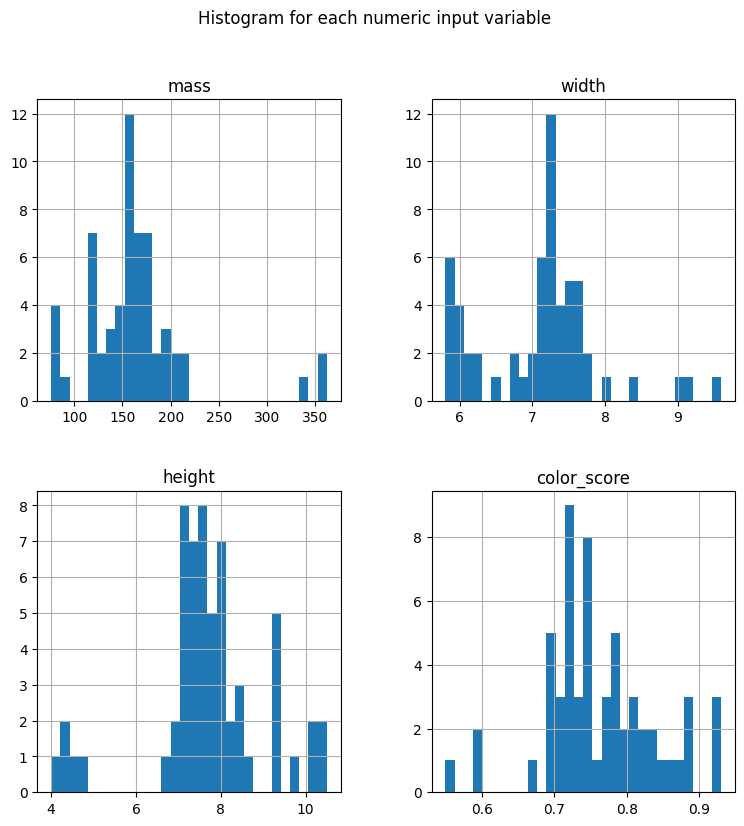

In [10]:
import pylab as pl
fruits.drop('fruit_label' ,axis=1).hist(bins=30, figsize=(9,9))
pl.suptitle("Histogram for each numeric input variable")
plt.savefig('fruits_hist')
plt.show()

It looks like perhaps color score has a near Gaussian distribution.

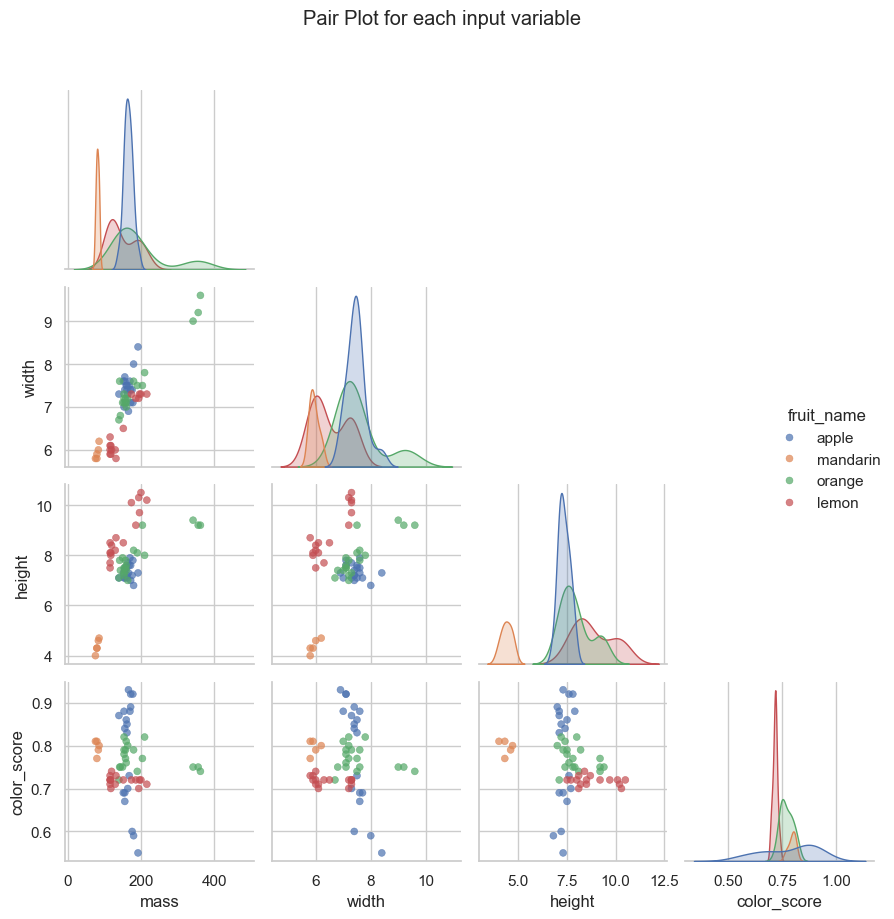

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# numeric features only (exclude label)
num_cols = fruits.select_dtypes(include='number').columns.drop('fruit_label', errors='ignore')

sns.set_theme(style='whitegrid')
g = sns.pairplot(
    data=fruits,
    vars=num_cols,
    hue='fruit_name',
    diag_kind='kde',
    corner=True, 
    plot_kws=dict(s=25, alpha=0.7, edgecolor=None)
)

g.fig.set_size_inches(9, 9)
g.fig.suptitle('Pair Plot for each input variable', y=1.02)
g.fig.tight_layout()
g.fig.subplots_adjust(top=0.93)
g.savefig('fruits_pairplot.png', dpi=150, bbox_inches='tight')
plt.show()


Correlation Heatmap Analysis

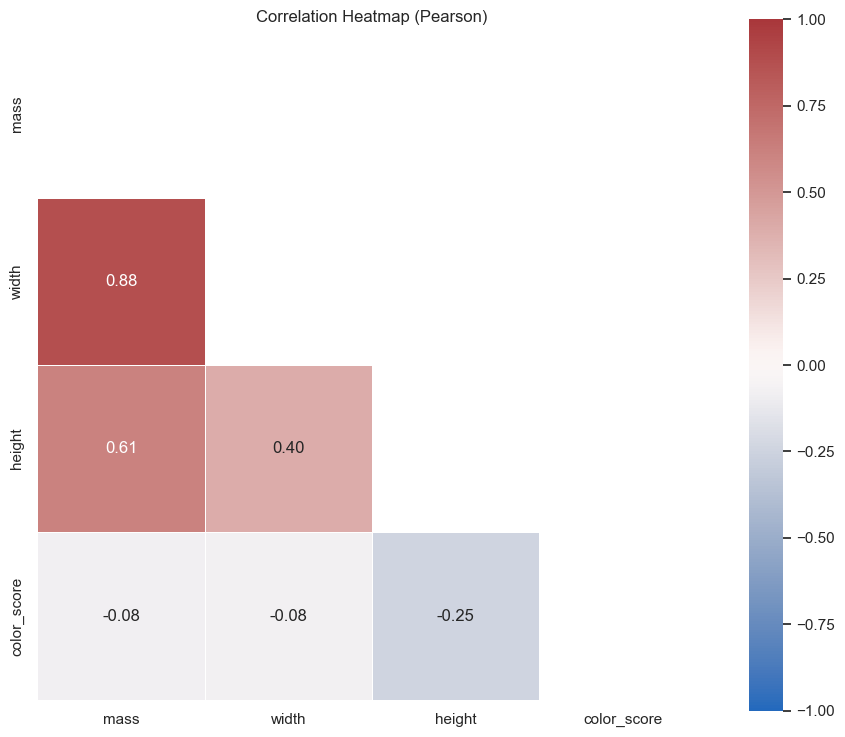

In [12]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# numeric features only (exclude label if present)
num_df = fruits.drop(columns='fruit_label', errors='ignore').select_dtypes(include='number')

corr = num_df.corr(method='pearson')  # or 'spearman'
mask = np.triu(np.ones_like(corr, dtype=bool))

sns.set_theme(style='white')
plt.figure(figsize=(9, 9))
ax = sns.heatmap(
    corr, mask=mask, cmap='vlag', vmin=-1, vmax=1,
    annot=True, fmt='.2f', square=True, linewidths=.5,
    cbar_kws=dict(shrink=.8)
)
plt.title('Correlation Heatmap (Pearson)')
plt.tight_layout()
plt.savefig('fruits_corr_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()
# Tip: set annot=False if many features to declutter


Observation  
Some pairs of attributes are correlated (mass and width). This suggests a high correlation and a predictable relationship

## Modelling: Data Preparation

### Create training and test sets

In [13]:
from sklearn.model_selection import train_test_split
feature_names = ['mass', 'width', 'height', 'color_score']
X = fruits[feature_names]
y = fruits['fruit_label']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [14]:
num_cols = X_train.select_dtypes(include='number').columns
n = len(num_cols)
cols = 2
rows = ceil(n / cols)

# --- Create subplots ---
fig = make_subplots(
    rows=rows, cols=cols,
    subplot_titles=num_cols,
    horizontal_spacing=0.08,
    vertical_spacing=0.1
)

# --- Add histograms ---
bins = 30
density = False

for i, col in enumerate(num_cols):
    r = i // cols + 1
    c = i % cols + 1

    a = X_train[col].dropna().values
    b = X_test[col].dropna().values

    # Shared bin edges for fair comparison
    if a.size and b.size:
        lo, hi = min(a.min(), b.min()), max(a.max(), b.max())
        if lo < hi:
            edges = np.linspace(lo, hi, bins + 1)
        else:
            edges = bins
    else:
        edges = bins

    # Train histogram
    fig.add_trace(
        go.Histogram(
            x=a,
            name='Train',
            nbinsx=bins,
            xbins=dict(start=edges[0], end=edges[-1], size=(edges[-1] - edges[0]) / bins) if isinstance(edges, np.ndarray) else None,
            opacity=0.5,
            marker_color='#1f77b4',
            histnorm='probability' if density else None
        ),
        row=r, col=c
    )

    # Test histogram
    fig.add_trace(
        go.Histogram(
            x=b,
            name='Test',
            nbinsx=bins,
            xbins=dict(start=edges[0], end=edges[-1], size=(edges[-1] - edges[0]) / bins) if isinstance(edges, np.ndarray) else None,
            opacity=0.5,
            marker_color='#ff7f0e',
            histnorm='probability' if density else None
        ),
        row=r, col=c
    )

# --- Layout & Aesthetics ---
fig.update_layout(
    height=400 * rows, width=700,
    title_text='Train vs Test Histograms',
    showlegend=True,
    legend=dict(x=0.9, y=1.05),
    barmode='overlay',
    margin=dict(l=40, r=20, t=80, b=40),
)

fig.update_xaxes(showgrid=True)
fig.update_yaxes(showgrid=True)

# --- Show and/or save ---
# fig.write_html('train_test_histograms.html')
fig.show()
# Optional static export:
# fig.write_image('train_test_histograms.png', scale=2)


### Apply MinMax scaling

In [15]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Modelling: Base Model Testing

### Logistic Regression

In [16]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

print('Accuracy of Logistic regression classifier on training set: {:.2f}'
     .format(logreg.score(X_train, y_train)))
print('Accuracy of Logistic regression classifier on test set: {:.2f}'
     .format(logreg.score(X_test, y_test)))

Accuracy of Logistic regression classifier on training set: 0.75
Accuracy of Logistic regression classifier on test set: 0.47


### Decision Tree

In [17]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier().fit(X_train, y_train)

print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))
print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

Accuracy of Decision Tree classifier on training set: 1.00
Accuracy of Decision Tree classifier on test set: 0.67


#### Setting max decision tree depth to help avoid overfitting

In [18]:
clf2 = DecisionTreeClassifier(max_depth=3).fit(X_train, y_train)
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf2.score(X_train, y_train)))
print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(clf2.score(X_test, y_test)))

Accuracy of Decision Tree classifier on training set: 0.89
Accuracy of Decision Tree classifier on test set: 0.73


### K-Nearest Neighbors

In [19]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(X_test, y_test)))

Accuracy of K-NN classifier on training set: 0.95
Accuracy of K-NN classifier on test set: 1.00


### Linear Discriminant Analysis

In [20]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)
print('Accuracy of LDA classifier on training set: {:.2f}'
     .format(lda.score(X_train, y_train)))
print('Accuracy of LDA classifier on test set: {:.2f}'
     .format(lda.score(X_test, y_test)))

Accuracy of LDA classifier on training set: 0.86
Accuracy of LDA classifier on test set: 0.67


### Gaussian Naive Bayes

In [21]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(X_train, y_train)
print('Accuracy of GNB classifier on training set: {:.2f}'
     .format(gnb.score(X_train, y_train)))
print('Accuracy of GNB classifier on test set: {:.2f}'
     .format(gnb.score(X_test, y_test)))

Accuracy of GNB classifier on training set: 0.86
Accuracy of GNB classifier on test set: 0.67


### Support Vector Machine

In [22]:
from sklearn.svm import SVC

svm = SVC()
svm.fit(X_train, y_train)
print('Accuracy of SVM classifier on training set: {:.2f}'
     .format(svm.score(X_train, y_train)))
print('Accuracy of SVM classifier on test set: {:.2f}'
     .format(svm.score(X_test, y_test)))

Accuracy of SVM classifier on training set: 0.91
Accuracy of SVM classifier on test set: 0.80


The KNN algorithm was the most accurate model that we tried. The confusion matrix provides an indication of one error made.

Finally, the classification report provides a breakdown of each class by precision, recall, f1-score and support showing excellent results (However, the test set was small).

In [23]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
pred = knn.predict(X_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

[[4 0 0 0]
 [0 1 0 0]
 [0 0 8 0]
 [0 0 0 2]]
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         4
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         8
           4       1.00      1.00      1.00         2

    accuracy                           1.00        15
   macro avg       1.00      1.00      1.00        15
weighted avg       1.00      1.00      1.00        15



### Plot the decision boundary of the k-nn classifier

In [24]:
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.patches as mpatches
import matplotlib.patches as mpatches
import sklearn.neighbors as neighbors

X = fruits[['mass', 'width', 'height', 'color_score']]
y = fruits['fruit_label']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

def plot_fruit_knn(X, y, n_neighbors, weights):
    X_mat = X[['height', 'width']].values
    y_mat = y.values

    # Create color maps
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF','#AFAFAF'])
    cmap_bold  = ListedColormap(['#FF0000', '#00FF00', '#0000FF','#AFAFAF'])

    clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights)
    clf.fit(X_mat, y_mat)

    # Plot the decision boundary by assigning a color in the color map
    # to each mesh point.
    
    mesh_step_size = .01  # step size in the mesh
    plot_symbol_size = 50
    
    x_min, x_max = X_mat[:, 0].min() - 1, X_mat[:, 0].max() + 1
    y_min, y_max = X_mat[:, 1].min() - 1, X_mat[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, mesh_step_size),
                         np.arange(y_min, y_max, mesh_step_size))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot training points
    plt.scatter(X_mat[:, 0], X_mat[:, 1], s=plot_symbol_size, c=y, cmap=cmap_bold, edgecolor = 'black')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

    patch0 = mpatches.Patch(color='#FF0000', label='apple')
    patch1 = mpatches.Patch(color='#00FF00', label='mandarin')
    patch2 = mpatches.Patch(color='#0000FF', label='orange')
    patch3 = mpatches.Patch(color='#AFAFAF', label='lemon')
    plt.legend(handles=[patch0, patch1, patch2, patch3])

        
    plt.xlabel('height (cm)')
    plt.ylabel('width (cm)')
    plt.title("4-Class classification (k = %i, weights = '%s')"
              % (n_neighbors, weights))
    
    plt.show()

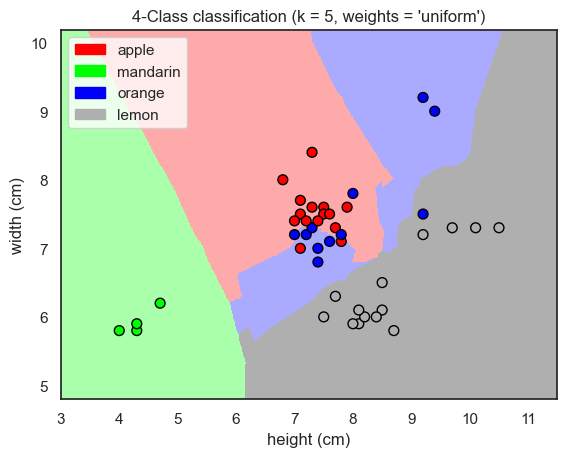

In [25]:
plot_fruit_knn(X_train, y_train, 5, 'uniform')

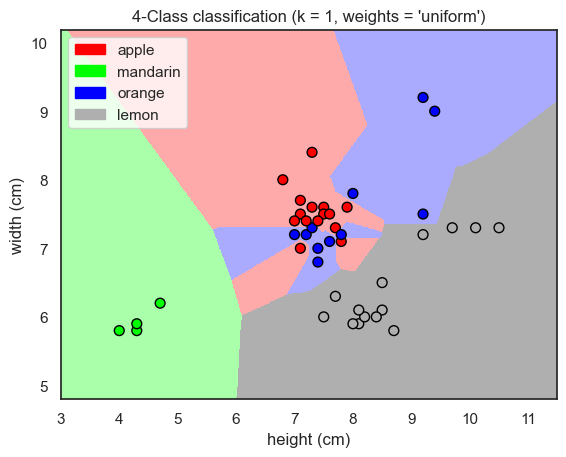

In [26]:
plot_fruit_knn(X_train, y_train, 1, 'uniform')

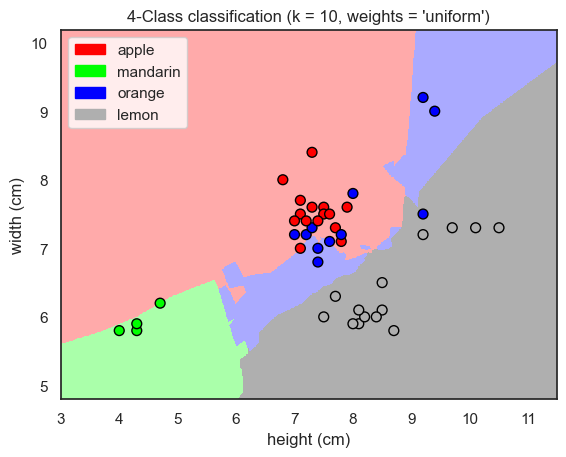

In [27]:
plot_fruit_knn(X_train, y_train, 10, 'uniform')

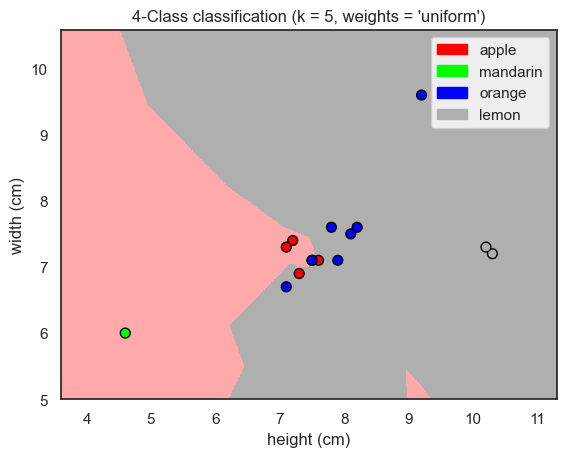

In [28]:
plot_fruit_knn(X_test, y_test, 5, 'uniform')

([<matplotlib.axis.XTick at 0x193ddeac690>,
 [Text(0, 0, '0'),
  Text(5, 0, '5'),
  Text(10, 0, '10'),
  Text(15, 0, '15'),
  Text(20, 0, '20')])

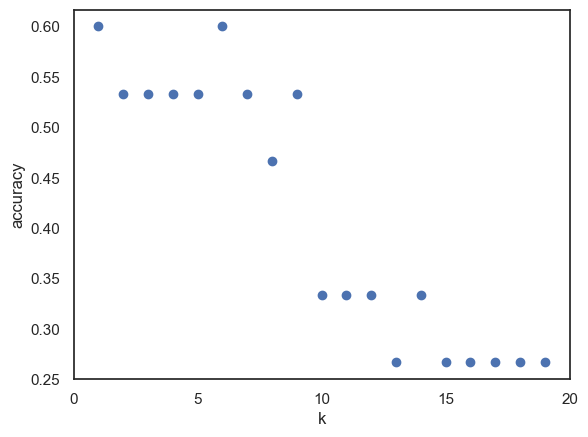

In [29]:
k_range = range(1, 20)
scores = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    scores.append(knn.score(X_test, y_test))
plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.xticks([0,5,10,15,20])

For this particular dateset, we obtain the highest accuracy when k=5.

## Modelling: Auto ML

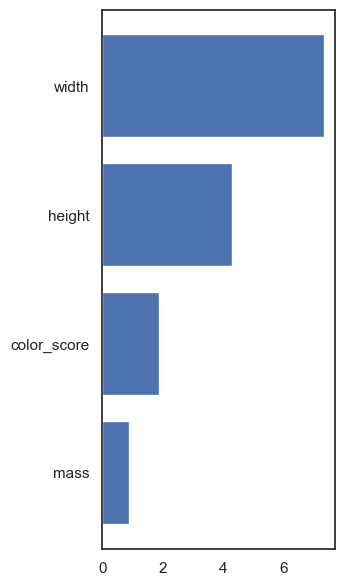

NameError: name 'start_time' is not defined

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

Number_trials = 20


def train_knn(X, y):
    score_train = []
    score_test = []

    for seed in range(Number_trials):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)
        scaler = MinMaxScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        # avoid asking for more neighbors than training samples
        # max_k = min(70, len(X_train))
        neighbors_settings = range(1, 40)

        acc_train = []
        acc_test = []

        for n_neighbors in neighbors_settings:
            clf = KNeighborsClassifier(n_neighbors=n_neighbors)
            clf.fit(X_train, y_train)
            acc_train.append(clf.score(X_train, y_train))
            acc_test.append(clf.score(X_test, y_test))

        score_train.append(acc_train)
        score_test.append(acc_test)

    score = np.mean(score_test, axis=0)
    run_time = (time.time() - start_time)
    return ['kNN', np.amax(score), f'N_Neighbor = {np.argmax(score)+1}', 'NA', run_time]


def train_logistic(X, y, reg):
    C = [1e-8, 1e-4, 1e-3, 1e-2, 0.1, 0.2, 0.4, 0.75, 1, 1.5, 3, 5, 10, 15, 20, 100, 1000, 10000,1e8]
    score_train = []
    score_test = []
    weighted_coefs = []

    for seed in range(Number_trials):
        training_accuracy = []
        test_accuracy = []
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)
        scaler = MinMaxScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        for alpha_run in C:
            if reg == 'l1':
                lr = LogisticRegression(C=alpha_run, penalty=reg, solver='liblinear', max_iter=5000).fit(X_train, y_train)
            elif reg == 'l2':
                lr = LogisticRegression(C=alpha_run, penalty=reg, solver='lbfgs', max_iter=5000).fit(X_train, y_train)

            training_accuracy.append(lr.score(X_train, y_train))
            test_accuracy.append(lr.score(X_test, y_test))
            weighted_coefs.append(lr.coef_)

        score_train.append(training_accuracy)
        score_test.append(test_accuracy)

    mean_coefs = np.mean(weighted_coefs, axis=0)
    score = np.mean(score_test, axis=0)

    flat_coefs = np.abs(mean_coefs).ravel()[:len(X.columns)]
    top_predictor = X.columns[np.argmax(flat_coefs)]

    abs_mean_coefs = np.abs(mean_coefs[0, :])
    coefs_count = len(abs_mean_coefs)
    fig, ax = plt.subplots(figsize=(3, 3 + coefs_count))
    ax.barh(np.arange(coefs_count), sorted(abs_mean_coefs))
    ax.set_yticks(np.arange(coefs_count))
    ax.set_yticklabels(X.columns[np.argsort(abs_mean_coefs)])
    plt.show()

    run_time = (time.time() - start_time)
    return [f'Logistic ({reg})', np.amax(score),
            f'C = {C[np.argmax(score)]}', top_predictor, run_time]


def train_svm(X, y, reg):
    C = [1e-8, 1e-4, 1e-3, 1e-2, 0.1, 0.2, 0.4, 0.75, 1, 1.5, 3, 5, 10, 15, 20, 100, 1000, 10000, 1e8]
    score_train = []
    score_test = []
    weighted_coefs = []

    for seed in range(Number_trials):
        training_accuracy = []
        test_accuracy = []
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)
        scaler = MinMaxScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        
        for alpha_run in C:
            if reg == 'l1':
                svc = LinearSVC(C=alpha_run, penalty=reg, loss='squared_hinge', dual=False, max_iter=5000).fit(X_train, y_train)
            elif reg == 'l2':
                svc = LinearSVC(C=alpha_run, penalty=reg, max_iter=5000).fit(X_train, y_train)

            training_accuracy.append(svc.score(X_train, y_train))
            test_accuracy.append(svc.score(X_test, y_test))
            weighted_coefs.append(svc.coef_)

        score_train.append(training_accuracy)
        score_test.append(test_accuracy)

    mean_coefs = np.mean(weighted_coefs, axis=0)
    score = np.mean(score_test, axis=0)

    flat_coefs = np.abs(mean_coefs).ravel()[:len(X.columns)]
    top_predictor = X.columns[np.argmax(flat_coefs)]

    abs_mean_coefs = np.abs(mean_coefs[0, :])
    coefs_count = len(abs_mean_coefs)
    fig, ax = plt.subplots(figsize=(3, 3 + coefs_count))
    ax.barh(np.arange(coefs_count), sorted(abs_mean_coefs))
    ax.set_yticks(np.arange(coefs_count))
    ax.set_yticklabels(X.columns[np.argsort(abs_mean_coefs)])
    plt.show()

    run_time = (time.time() - start_time)
    return [f'Linear SVM ({reg})', np.amax(score),
            f'C = {C[np.argmax(score)]}', top_predictor, run_time]

def train_rf(X, y):
    score_train = []
    score_test = []
    best_params = []
    best_estimators = []

    for seed in range(10):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)
        scaler = MinMaxScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        param_grid = {
        'n_estimators': [50, 100, 150, 200],  # Number of trees in the forest
        'max_depth': list(range(1, 6)),      # Maximum depth of individual trees
        'max_features': ['sqrt'] # Number of features to consider when looking for the best split
        }

        rf = RandomForestClassifier(random_state=0)
        grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
        grid_search.fit(X_train, y_train)
        score_train.append(grid_search.score(X_train, y_train))
        score_test.append(grid_search.score(X_test, y_test))
        best_params.append(grid_search.best_params_)
        best_estimators.append(grid_search.best_estimator_)

    best_estimator = best_estimators[np.argmax(score_test)]
    score = np.mean(score_test, axis=0)
    run_time = (time.time() - start_time)
    return ['Random Forest', np.amax(score), str(best_params[np.argmax(score_test)]), \
            X.columns[np.argmax(best_estimator.feature_importances_)], run_time]

def train_gbm(X, y):
    score_train = []
    score_test = []
    best_params = []
    best_estimators = []

    for seed in range(10):
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)
        scaler = MinMaxScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        param_grid = {
        'n_estimators': [50, 100, 150, 200],  # Number of trees in the forest
        'learning_rate': [0.01, 0.05, 0.1, 0.5, 1]    # Learning Rate
        }

        gbm = GradientBoostingClassifier(random_state=0)
        grid_search = GridSearchCV(estimator=gbm, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
        grid_search.fit(X_train, y_train)
        score_train.append(grid_search.score(X_train, y_train))
        score_test.append(grid_search.score(X_test, y_test))
        best_params.append(grid_search.best_params_)
        best_estimators.append(grid_search.best_estimator_)

    best_estimator = best_estimators[np.argmax(score_test)]
    score = np.mean(score_test, axis=0)
    run_time = (time.time() - start_time)
    return ['Gradient Boosting Method', np.amax(score), str(best_params[np.argmax(score_test)]), \
            X.columns[np.argmax(best_estimator.feature_importances_)], run_time]

feature_names = ['mass', 'width', 'height', 'color_score']
X_raw = fruits[feature_names]
XX_normalized = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
y = fruits['fruit_label']

b = train_logistic(X_raw, y, reg='l2')
start_time = time.time()


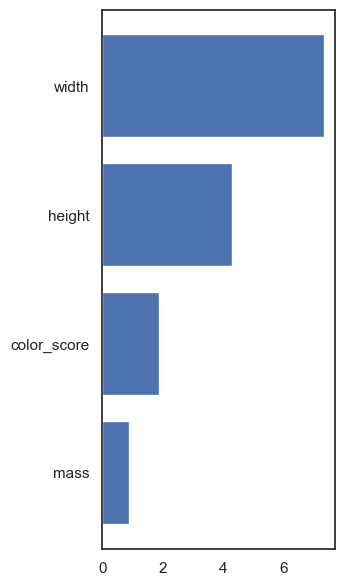

c:\Users\Enzo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1288: FutureWarning:

Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.

c:\Users\Enzo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1288: FutureWarning:

Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.

c:\Users\Enzo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1288: FutureWarning:

Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised 

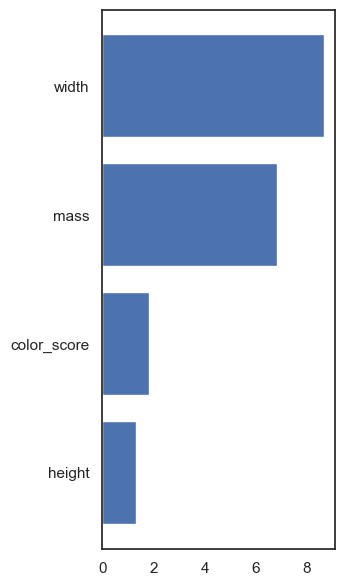

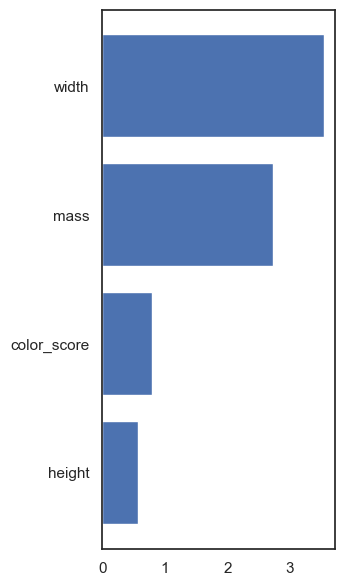

c:\Users\Enzo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\Users\Enzo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.

c:\Users\Enzo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\svm\_base.py:1250: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



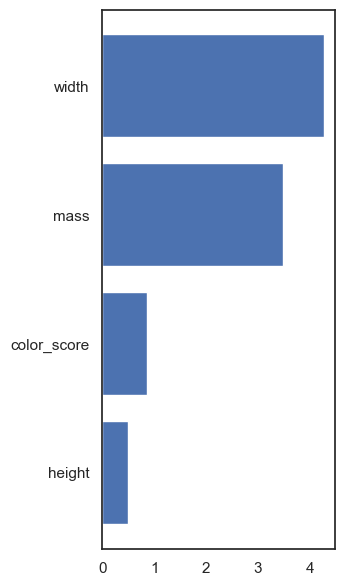

Fitting 5 folds for each of 20 candidates, totalling 100 fits


c:\Users\Enzo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.



Fitting 5 folds for each of 20 candidates, totalling 100 fits


c:\Users\Enzo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.



Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits


c:\Users\Enzo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning:

The least populated class in y has only 3 members, which is less than n_splits=5.



Fitting 5 folds for each of 20 candidates, totalling 100 fits


c:\Users\Enzo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning:

The least populated class in y has only 2 members, which is less than n_splits=5.



Fitting 5 folds for each of 20 candidates, totalling 100 fits


c:\Users\Enzo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning:

The least populated class in y has only 3 members, which is less than n_splits=5.



Fitting 5 folds for each of 20 candidates, totalling 100 fits


c:\Users\Enzo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning:

The least populated class in y has only 3 members, which is less than n_splits=5.



Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits


c:\Users\Enzo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning:

The least populated class in y has only 2 members, which is less than n_splits=5.



Fitting 5 folds for each of 20 candidates, totalling 100 fits


c:\Users\Enzo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.



Fitting 5 folds for each of 20 candidates, totalling 100 fits


c:\Users\Enzo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning:

The least populated class in y has only 4 members, which is less than n_splits=5.



Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits


c:\Users\Enzo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning:

The least populated class in y has only 3 members, which is less than n_splits=5.



Fitting 5 folds for each of 20 candidates, totalling 100 fits


c:\Users\Enzo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning:

The least populated class in y has only 2 members, which is less than n_splits=5.



Fitting 5 folds for each of 20 candidates, totalling 100 fits


c:\Users\Enzo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning:

The least populated class in y has only 3 members, which is less than n_splits=5.



Fitting 5 folds for each of 20 candidates, totalling 100 fits


c:\Users\Enzo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning:

The least populated class in y has only 3 members, which is less than n_splits=5.



Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits


c:\Users\Enzo\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\model_selection\_split.py:811: UserWarning:

The least populated class in y has only 2 members, which is less than n_splits=5.



['kNN', np.float64(0.9466666666666667), 'N_Neighbor = 1', 'NA', 8.035084962844849]
8.035084962844849 seconds
['Logistic (l2)', np.float64(0.8233333333333335), 'C = 100000000.0', 'width', 1.576291561126709]
1.576291561126709 seconds
['Logistic (l1)', np.float64(0.73), 'C = 10000', 'width', 0.523651123046875]
0.523651123046875 seconds
['Linear SVM (l2)', np.float64(0.7033333333333333), 'C = 10000', 'width', 0.5582380294799805]
0.5582380294799805 seconds
['Linear SVM (l1)', np.float64(0.7033333333333334), 'C = 100', 'width', 0.6170394420623779]
0.6170394420623779 seconds
['Random Forest', np.float64(0.9400000000000001), "{'max_depth': 4, 'max_features': 'sqrt', 'n_estimators': 50}", 'color_score', 12.349209308624268]
12.349209308624268 seconds
['Gradient Boosting Method', np.float64(0.8866666666666667), "{'learning_rate': 0.5, 'n_estimators': 50}", 'color_score', 15.085033893585205]
15.085033893585205 seconds


In [50]:
from sklearn.preprocessing import MinMaxScaler
#scaler = MinMaxScaler()
#XX = scaler.fit_transform(XX.astype(np.float)) #You will loss the column names

scaler = MinMaxScaler()

feature_names = ['mass', 'width', 'height', 'color_score']
X_raw = fruits[feature_names]
XX_normalized = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
y = fruits['fruit_label']



import time

start_time = time.time()
a = train_knn(X_raw, y)
start_time = time.time()
b = train_logistic(X_raw, y, reg='l2')
start_time = time.time()
c = train_logistic(X_raw, y, reg='l1')
start_time = time.time()
d = train_svm(X_raw, y, reg='l2')
start_time = time.time()
e = train_svm(X_raw, y, reg='l1')
start_time = time.time()
f = train_rf(X,y)
start_time = time.time()
g = train_gbm(X,y)

print(a)
print("%s seconds" % a[4])
print(b)
print("%s seconds" % b[4])
print(c)
print("%s seconds" % c[4])
print(d)
print("%s seconds" % d[4])
print(e)
print("%s seconds" % e[4])
print(f)
print("%s seconds" % f[4])
print(g)
print("%s seconds" % g[4])



In [52]:
cols = ['Machine Learning Method', 'Test Accuracy', 'Best Parameter', 'Top Predictor Variable', 'Run Time']
df2 = pd.DataFrame(columns=cols)

df2.loc[0] = a
df2.loc[1] = b
df2.loc[2] = c
df2.loc[3] = d
df2.loc[4] = e
df2.loc[5] = f
df2.loc[6] = g

df2

,Machine Learning Method,Test Accuracy,Best Parameter,Top Predictor Variable,Run Time
0,kNN,0.946667,N_Neighbor = 1,NA,8.035085
1,Logistic (l2),0.823333,C = 100000000.0,width,1.576292
2,Logistic (l1),0.730000,C = 10000,width,0.523651
3,Linear SVM (l2),0.703333,C = 10000,width,0.558238
4,Linear SVM (l1),0.703333,C = 100,width,0.617039
5,Random Forest,0.940000,"{'max_depth': 4, 'max_features': 'sqrt', 'n_es...",color_score,12.349209
6,Gradient Boosting Method,0.886667,"{'learning_rate': 0.5, 'n_estimators': 50}",color_score,15.085034
